# Finalized Marketing Images

---

## Overview

Narrowing scope to those images of interest provided by @nisha on the Behaviorally.


## Setup


### Working Directory

This just helps with using local imports from the larger project to the notebook.

In [1]:
cd ../

/Users/chrismessier/work/behaviorally


### Imports

In [2]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from numpy import random as rng
import matplotlib as mpl
from matplotlib import pyplot as plt
from google.protobuf.struct_pb2 import Struct
from clarifai_grpc.channel.clarifai_channel import ClarifaiChannel
from clarifai_grpc.grpc.api import resources_pb2, service_pb2, service_pb2_grpc
from clarifai_grpc.grpc.api.status import status_pb2, status_code_pb2

import processors
import tools

#### Config

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# for replicability
rng.seed(42)
# rng.seed(304)

In [5]:
%matplotlib inline

mpl.rcParams['figure.figsize'] = (12, 9)

sns.set(
    style='darkgrid'
)

In [6]:
from config import KEY_METRICS,\
    KEY_CONDITIONALS,\
    TO_NORMALIZE,\
    ONS_ANALYSIS_JOB_NUMBERS,\
    IMAGES_OF_INTEREST

In [7]:
N = 51  # sample size for images, keep LOW for dev

In [8]:
OUTPUT_DIR = "/Users/chrismessier/work/behaviorally/outputs/finalized-marketing-images"

#### Functions

In [9]:
def __clean_filename(s, is_executable=False):
    return '-'.join([s_.lower() for s_ in s.split()])

In [10]:
from tools.plotting import plot_series

In [11]:
# NOTE now found in tools.plotting
# def plot_series(data, x, y, title=None, period_length=13):
#     g = sns.lineplot(
#         x=x,
#         y=y,
#         hue='Image ID', # hue='Brand Name', # hue="Image Name",  # hue="Product",
#         data=data,
#         legend=True
#     )

#     plt.title(title)
#     plt.xlim((0,156))  # for the items not just in single periods
#     plt.xlabel(x)
#     plt.ylabel(y)
#     plt.tight_layout()
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#     g.set_xticks(range(data['report_dates'].nunique())) # <--- set the ticks first
#     g.set_xticklabels([t.strftime('%b %d, %Y') for t in data['report_dates'].unique()])

#     for i, label in enumerate(g.xaxis.get_ticklabels()):
#         if ((i+1) % period_length) == 0:
#             label.set_visible(True)
#         else:
#             label.set_visible(False)

#     plt.xticks(rotation=45)

#     plt.show()


## Analysis

We were provided some instructions by @nisha:

>In the file below, we have now included one more column where we have added the names of the images linked to the UPC codes. This is column G, existing images.
>
>[Copy of IRI Data Product List_3.21.22.xlsx](https://nam12.safelinks.protection.outlook.com/ap/x-59584e83/?url=https%3A%2F%2Fbehav-my.sharepoint.com%2F%3Ax%3A%2Fg%2Fpersonal%2Fskye_guggino_behaviorally_com%2FETyxthcQfnNCjDWRYGpOyAUBTTWqgqR0PhscL_OcLCtz3w%3Fe%3DYxFLgH&data=05%7C01%7CNisha.Yadav%40behaviorally.com%7C26bd690bb01c4c12456508da28923aff%7C01c55d0a027b47dfa914b27f0803c8b4%7C0%7C0%7C637866905773423479%7CUnknown%7CTWFpbGZsb3d8eyJWIjoiMC4wLjAwMDAiLCJQIjoiV2luMzIiLCJBTiI6Ik1haWwiLCJXVCI6Mn0%3D%7C3000%7C%7C%7C&sdata=guPGh3h2T6WhrVY1a3JRqhhs%2FRU8cgquntzsShArcaE%3D&reserved=0)
>
>In column H, Scraped Online images, you will find names of image files scraped from the internet. Most of the images in this column match or are very similar to the images in column H. there are a few that are a bit different, 13 in all, and are highlighted in red.
>
>For the analysis you shared on Tuesday, please do another run where you filter by ONS scores for the images listed in column H. then, please apply another filter and take out the 13 red ones from column G.
>
>Now, as we were discussing on Tuesday, we not only need a correlation analysis, but also need a linear regression, to understand the relationship between the ONS and sales metrics from IRI. Once you have the clean file, would you run this as well?
>
>Thanks, ny


>In the file below, we have now included one more column where we have added the names of the images linked to the UPC codes. This is column G, existing images.



In [12]:
images_of_interest = IMAGES_OF_INTEREST

In [13]:
len(images_of_interest)

51

In [14]:
data = "/Users/chrismessier/work/behaviorally/data/behaviorally_merged_sales_data.csv"

In [15]:
df = pd.read_csv(data, index_col=0)


In [16]:
df['report_dates'] = tools.infer_report_dates(df['REPORT'].values)


In [17]:
df.drop(columns=['upc', 'upc_10', 'UPC 10 digit'], inplace=True)

In [18]:
df.sample(1)

,Image Name,Image ID,Raw ONS Line and Pack,job_number,Product,Dollar Sales,Dollar Sales % Change vs YA,Unit Sales,Unit Sales % Change vs YA,Unit Share of Category,Unit Share of Category Year Ago,Unit Share of SubCategory,Unit Share of SubCategory Year Ago,Price per Unit,Price per Unit % Change vs YA,Category Name,Sub-Category Name,Brand Name,REPORT,report_dates
154,AD112_PACK1B.jpg,PACK1B,15.0,AD112,REMY MARTIN 1738 ACCORD ROYAL REGULAR LIQUEUR ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SPIRITS/LIQUOR,SPIRITS,REMY MARTIN 1738 ACCORD ROYAL,151.0,2022-02-20


In [19]:
df = df[df['Image Name'].isin(images_of_interest)].copy()
df = df.infer_objects()


In [20]:
missing_images = [f for f in images_of_interest if f not in df['Image Name'].values.tolist()]
print(f'Total missing images: {len(missing_images)}')
print(missing_images)

Total missing images: 3
['AD692_LINE1.png', 'L2115_LINE1.jpg', 'AD615_LINE1.jpg']


In [21]:
df = df.dropna(subset=['REPORT']).copy()  # don't want rows (items) that aren't associated with any observations 


In [22]:
missing_images = set([f for f in images_of_interest if f not in df['Image Name'].values.tolist()])
print(f'Total missing images: {len(missing_images)}')
print(missing_images)


Total missing images: 12
{'AD615_LINE1.jpg', 'AD697_LINE1.jpg', 'L2115_LINE1.jpg', 'AD507_LINE1A.jpg', 'AC296_LINE1.jpg', 'AD387_PACK1.jpg', 'AD518_LINE1.jpg', 'AC638_PACK1.jpg', 'AD296_PACK1.jpg', 'AD692_LINE1.png', 'AD672_LINE1.jpg', 'L1501_LINE1.jpg'}


It looks like some of the items aren't even in the reports...?

The file `'L2115_LINE1.jpg'` is known to be missing, and examples have been provided by their team, however the other two were just identified now. 

### Normalize the Data

In [23]:
df_norm = df[['Image Name'] + TO_NORMALIZE].copy()
df_norm = df_norm.groupby('Image Name').transform(lambda x: (x - x.mean()) / x.std())

# df_norm.dropna(axis=1, inplace=True)
print(df_norm.shape)

(6240, 3)


In [24]:
df_norm.sample(3)

,Dollar Sales,Unit Sales,Price per Unit
249,-2.464528,-2.498102,2.015205
179,1.429813,1.413254,0.464387
0,-0.355391,-0.217456,-0.884462


In [25]:
columns_to_copy = ['Raw ONS Line and Pack', 'REPORT', 'Product', 'report_dates']
df_norm[columns_to_copy] = df.loc[:, columns_to_copy].copy()

In [26]:
df_norm.sample(3)

,Dollar Sales,Unit Sales,Price per Unit,Raw ONS Line and Pack,REPORT,Product,report_dates
271,0.757245,0.862769,0.067423,76.0,92.0,HARTZ OINKIES PORK AND CHICKEN CHEW DOG CHEW 8...,2021-01-03
229,0.637412,0.572562,-0.204190,67.0,91.0,CLASSICO TOMATO AND BASIL PASTA PASTA SAUCE FR...,2020-12-27
225,-0.801279,-0.870590,3.181884,40.0,154.0,ARNOLD PALMER SPIKED HALF & HALF ICED TEA LEMO...,2022-03-13


In [27]:
df_norm['report_dates'].min(), df_norm['report_dates'].max()

(Timestamp('2019-04-07 00:00:00'), Timestamp('2022-03-27 00:00:00'))

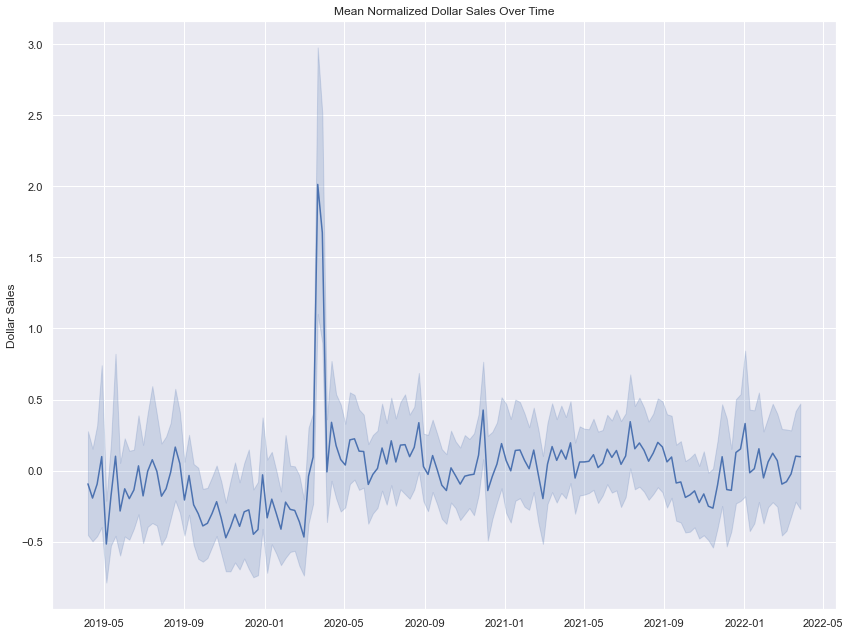

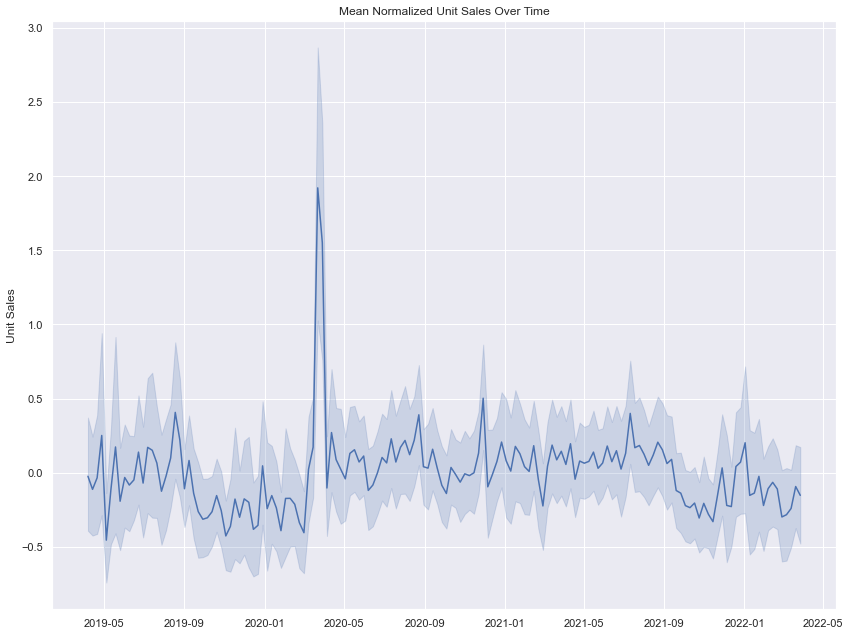

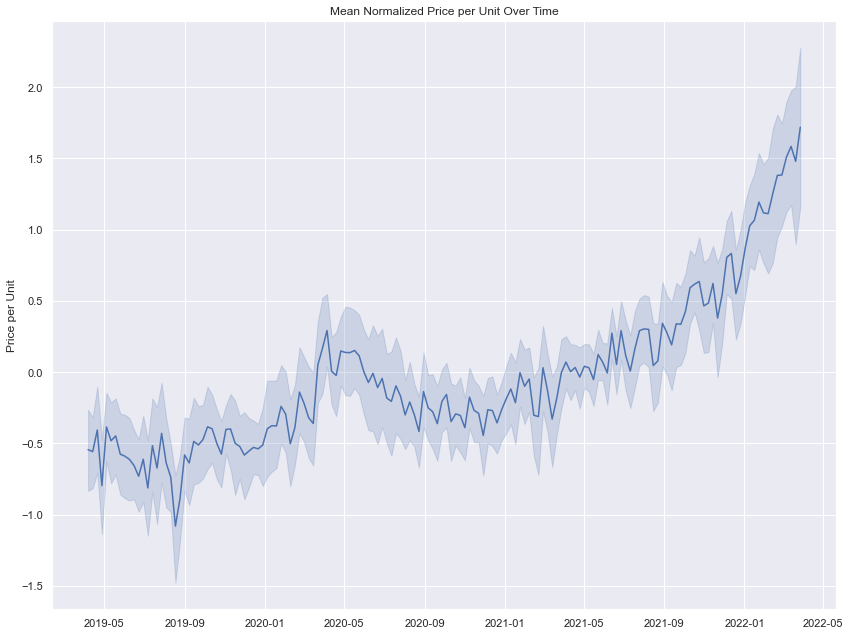

In [28]:
for y in TO_NORMALIZE:
    title = f"Mean Normalized {y} Over Time"
    title_ = __clean_filename(title)
    plt.title(title)
    sns.lineplot(
        data=df_norm,
        x='report_dates',
        y=y,
        # hue='Product',
        # style='Category Name',
        n_boot=1e4
    )
    plt.xlabel('')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, title_ + '.png'))
    plt.show()


Looking at the dates, I think I can see the source of that impact around 2020-03...

In [29]:
annual_inflation_rates = [
    2.3,  # 2019
    1.4,  # 2020
    7.0,  # 2021
    8.5,  # 2022 est.
]

In [30]:
annual_inflation_rates

[2.3, 1.4, 7.0, 8.5]

Correlations

In [31]:
from collections import defaultdict
x = 'Raw ONS Line and Pack'
correlations = defaultdict(list)
for report in df['REPORT'].unique():
    df_ = df[df['REPORT'] == report].copy()
    for y in TO_NORMALIZE:

        R = df_[x].corr(df_[y])
        correlations[y].append(R)


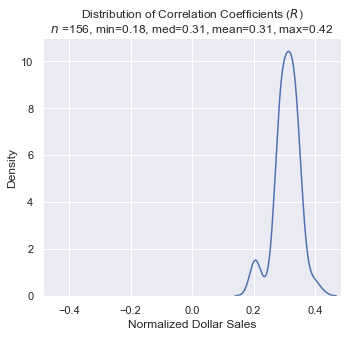

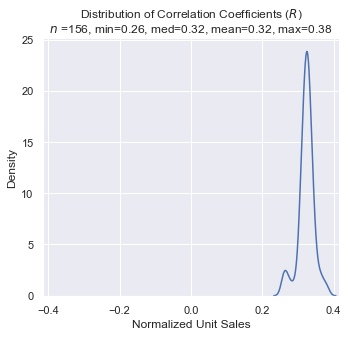

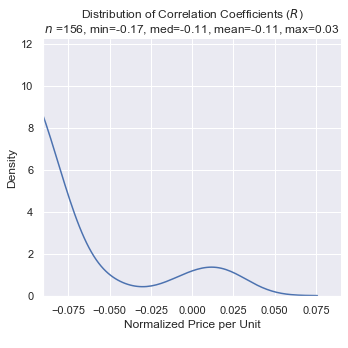

In [33]:
for k, v in correlations.items():
    stats = tools.desc_stats(v)
    msg = f"$n~$={len(v)}, min={stats['min']:.2f}, med={stats['median']:.2f}, mean={stats['mean']:.2f}, max={stats['max']:.2f}"

    g = sns.displot(v, kind='kde') # , bins=12)
    m_ = max(g.ax.get_xbound())
    g.ax.set_xbound((-1 * m_, m_))
    
    title = f"Distribution of Correlation Coefficients ($R$)\n"
    xlabel = f"Normalized {k}\n"
    sample_size = f"$n$={len(v)}"
    xlabel_ = __clean_filename(xlabel)

    plt.title(title+msg)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, xlabel_ + '.png'))
